# Genetic optimization of Bagging classifier for the SDSS data

## Load data

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
from helpers import DataSet
import matplotlib as mpl
import os
import random

# Common imports
import pandas as pd
import numpy as np
import seaborn as sns

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier, Perceptron
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

sdss_df_fe = sdss_data

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

class_names = ["GALAXY", "QSO", "STAR"]

std_scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_test = std_scaler.fit_transform(X_test.astype(np.float64))
X_train = std_scaler.fit_transform(X_train.astype(np.float64))

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


## Optimize

In [2]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV

paramgrid = {"base_estimator": [Perceptron(), DecisionTreeClassifier()],
             "n_estimators": np.logspace(2, 4, base=10, num=25, dtype=int),
             "max_samples": np.logspace(0, 2, base=10, num=25, dtype=int),
             "max_features": np.logspace(0, 2, base=10, num=25, dtype=int),
             "bootstrap": [True, False],
             "bootstrap_features": [False, True],
             "oob_score": [False, True],
             "n_jobs": [4],
             "random_state": [42],
             }

random.seed(1)

cv = EvolutionaryAlgorithmSearchCV(estimator=BaggingClassifier(),
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=5),
                                   verbose=3,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=15,
                                   n_jobs=8,
                                   error_score=0.0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result = cv.fit(X, y)

Types [1, 1, 1, 1, 1, 1, 1, 1, 1] and maxint [1, 24, 24, 24, 1, 1, 1, 0, 0] detected
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=562, max_samples=31, max_features=17, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=8254, max_samples=3, ma

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=825, max_samples=3, max_features=56, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=3162, max_samples=100, max_features=1, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s

[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estima

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=261, max_samples=46, max_features=82, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=825, max_samples=17, max_features=82, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.0, total=   0.0s

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1,

            splitter='best'), n_estimators=5623, max_samples=2, max_features=8, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=1778, max_samples=8, max_features=31, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=1778, max_samples=8, max_features=31, bootstrap=True

            splitter='best'), n_estimators=215, max_samples=1, max_features=82, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=1, max_features=17, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=261, max_samples=3, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=316, max_samples=1, max_features=5, bootstrap=True, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42, score=0.49975012493753124, total=   8.6s
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=146, max

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=261, max_samples=2, max_features=26, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=261, max_samples=2, max_features=26, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,


            splitter='best'), n_estimators=681, max_samples=1, max_features=5, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.49974987493746875, total=   1.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=681, max_samples=1, max_features=5, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm

            splitter='best'), n_estimators=464, max_samples=1, max_features=1, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.49975012493753124, total=   0.9s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=464, max_samples=1, max_features=1, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=261, max_samples=82, max_features=1, bootstrap=False, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=261, max_samples=82, max_features=1, bootstrap=False, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=261, max_samples=82, m

            splitter='best'), n_estimators=177, max_samples=3, max_features=46, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=177, max_samples=3, max_features=46, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_le

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=1000, max_samples=56, max_features=3, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.5, total=  12.5s
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=1000, max_samples=56, max_features=3, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_stat

            splitter='best'), n_estimators=383, max_samples=10, max_features=5, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=383, max_samples=10, max_features=5, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9450274862568716, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=3162, max_samples=4, max_features=2, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.8160919540229885, total=   5.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=3162, max_samples=4, max_features=2, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, w

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=10000, max_samples=6, max_features=38, bootstrap=True, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=10000, max_samples=6, max_features=38, bootstrap=True, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=10000, max_samples

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=14, max_features=1, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.8430784607696152, total=   3.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=464, max_samples=4, max_features=10, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=464, max_samples=4, max_features=10, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=464, max_samples=4

            splitter='best'), n_estimators=383, max_samples=68, max_features=12, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=383, max_samples=68, max_features=12, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_le

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=4641, max_samples=12, max_features=31, bootstrap=True, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=4641, max_samples=12, max_features=31, bootstrap=True, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=4641, max_samples=

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=3162, max_samples=26, max_features=3, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.5007496251874063, total= 1.3min
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=3162, max_samples=26, max_features=3, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=1000, m

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=3162, max_samples=26, max_features=3, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.49975012493753124, total= 1.2min
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=3162, max_samples=26, max_features=3, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=3162, 

            splitter='best'), n_estimators=100, max_samples=14, max_features=1, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 [CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=261, max_samples=46, max_features=82, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=261, max_samples=46, max_features=82, bootstrap=Fals

            splitter='best'), n_estimators=100, max_samples=14, max_features=1, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.8834417208604303, total=   0.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=383, max_samples=3, max_features=5, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fr

            splitter='best'), n_estimators=316, max_samples=3, max_features=8, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.6198099049524762, total=   1.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=3, max_features=8, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_frac

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=464, max_samples=10, max_features=38, bootstrap=False, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=464, max_samples=10, max_features=38, bootstrap=False, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=464, max_samples=10,

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9560219890054973, total=   2.9s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_feat

            splitter='best'), n_estimators=1467, max_samples=10, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9479739869934968, total=   2.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1467, max_samples=10, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=

            splitter='best'), n_estimators=1467, max_samples=10, max_features=1, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=146, max_samples=26, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.5092546273136568, total=   2.4s
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=146, max_samples=26, max_features=

            splitter='best'), n_estimators=1467, max_samples=10, max_features=1, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=3, max_features=4, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.8095952023988006, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=1000, max_samples=3, max_features=8, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=1, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.842, total=   5.3s[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_lea

            splitter='best'), n_estimators=1000, max_samples=3, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1000, max_samples=3, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf

            splitter='best'), n_estimators=121, max_samples=3, max_features=3, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=121, max_samples=3, max_features=3, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.8299149574787393, total=   0.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fr

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=316, max_samples=3, max_features=8, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.49975012493753124, total=   4.2s
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=316, max_samples=3, max_features=8, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=316,

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=1467, max_samples=10, max_features=8, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.49974987493746875, total=  18.8s
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=5623, max_samples=5, max_features=8, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.49975012493753124, total= 1.1min
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbo

            splitter='best'), n_estimators=261, max_samples=10, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=3, max_features=8, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.848575712143928, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=261, max_samples=10, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=681, max_samples=10, max_features=5, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9495252373813093, total=   1.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=681, max_samples=10, max_features=5, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=681, max_samples=10, max_features=5, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9455, total=   1.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_le

            splitter='best'), n_estimators=215, max_samples=17, max_features=5, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9675162418790605, total=   3.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight

            splitter='best'), n_estimators=1778, max_samples=17, max_features=1, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9535232383808095, total=   3.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight

            splitter='best'), n_estimators=2610, max_samples=14, max_features=1, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.9535232383808095, total=   5.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=1, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.8735632183908046, total=   4.9s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=316, max_samples=1, max_features=5, bootstrap=True, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=1, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.8735632183908046, total=   4.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_sp

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9474737368684342, total=   2.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.954, total=   2.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_le

            splitter='best'), n_estimators=1467, max_samples=10, max_features=2, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=1, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.824087956021989, total=   3.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=1778, max_samples=17, max_features=1, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=3, max_features=1, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.6533266633316658, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight

            splitter='best'), n_estimators=1467, max_samples=10, max_features=2, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9489744872436218, total=   2.2s
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=1778, max_samples=26, max_features=100, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=1778, max_samples=26, max_feature

            splitter='best'), n_estimators=146, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=14, max_features=8, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9600199900049975, total=   4.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=2610, max_samples=14, max_features=8, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.966, total=   3.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=14, max_features=8, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_

            splitter='best'), n_estimators=681, max_samples=17, max_features=1, bootstrap=True, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42, score=0.8245877061469266, total=   2.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=681, max_samples=17, max_features=1, bootstrap=True, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_f

            splitter='best'), n_estimators=1778, max_samples=1, max_features=1, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.49975012493753124, total=   5.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=1, max_features=1, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_f

            splitter='best'), n_estimators=1467, max_samples=10, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9490254872563718, total=   2.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1467, max_samples=10, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_w

            splitter='best'), n_estimators=1778, max_samples=10, max_features=5, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9504752376188094, total=   3.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=10, max_features=5, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=1778, max_samples=10, max_features=5, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9554777388694348, total=   3.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=1, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=2610, max_samples=14, max_features=8, bootstrap=False, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=14, max_features=8, bootstrap=False, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf

            splitter='best'), n_estimators=146, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9224612306153076, total=   0.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=146, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=1778, max_samples=17, max_features=1, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.8735632183908046, total=   2.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=1, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=4641, max_samples=10, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.939, total=   8.5s[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9560219890054973, total=   3.1s

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_s

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.954, total=   2.3s[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9535232383808095, total=   3.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_spli

            splitter='best'), n_estimators=681, max_samples=10, max_features=5, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9415292353823088, total=   1.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=681, max_samples=10, max_features=5, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9825, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=4641, max_samples=10, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, ra

            splitter='best'), n_estimators=261, max_samples=14, max_features=8, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.960519740129935, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=14, max_features=8, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9609804902451226, total=   3.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=383, max_samples=14, max_features=8, bootstrap=False, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=383, max_samples=14, max_features=8, bootstrap=False, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0

            splitter='best'), n_estimators=1778, max_samples=14, max_features=8, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=10, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9485257371314343, total=   4.9s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we

            splitter='best'), n_estimators=2610, max_samples=10, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9295, total=   4.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=10, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fracti

            splitter='best'), n_estimators=2610, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9694847423711856, total=   3.9s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 [CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, rando

            splitter='best'), n_estimators=261, max_samples=10, max_features=8, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9155422288855573, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=10, max_features=8, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=681, max_samples=10, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9335332333833083, total=   1.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=681, max_samples=10, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9535232383808095, total=   2.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9505247376311844, total=   2.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_w

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.954, total=   2.9s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fractio

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9609804902451226, total=   2.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.9660169915042479, total=   1.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fr

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9560219890054973, total=   2.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=1778, max_samples=10, max_features=2, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=10, max_features=2, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_le

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9725, total=   2.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_l

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.954, total=   2.9s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_le

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9609804902451226, total=   2.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9560219890054973, total=   2.9s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=10000, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.953023488255872, total=  16.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9474737368684342, total=   2.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=1778, max_samples=17, max_features=8, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.968984492246123, total=   2.8s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9535232383808095, total=   2.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=1778, max_samples=38, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=38, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.9779889944972486, total=   4.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=261, max_samples=46, max_features=21, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=21, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf

            splitter='best'), n_estimators=261, max_samples=8, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.902, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=8, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0

            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9775112443778111, total=   3.7s[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9515242378810594, total=   3.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, mi

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9535232383808095, total=   2.9s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=2610, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9665167416291854, total=   4.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=2610, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9665167416291854, total=   4.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=2610, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, rand

            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0

            splitter='best'), n_estimators=2610, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.961480740370185, total=   4.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=6812, max_samples=14, max_features=8, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.9675162418790605, total=   6.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.9725, total=   6.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_lea

            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.9474737368684342, total=   4.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=261, max_samples=3, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.7838919459729865, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=3, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9655172413793104, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=2610, max_samples=14, max_features=100, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=14, max_features=100, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fractio

            splitter='best'), n_estimators=2610, max_samples=17, max_features=8, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9650174912543729, total=   4.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=17, max_features=8, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.968984492246123, total=   2.7s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=4641, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.968984492246123, total=   6.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_

            splitter='best'), n_estimators=2610, max_samples=17, max_features=8, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=215, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9724862431215607, total=   0.3s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.9704852426213106, total=   4.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 [CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, ran

            splitter='best'), n_estimators=215, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9665167416291854, total=   0.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=215, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=261, max_samples=38, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random

            splitter='best'), n_estimators=215, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9724862431215607, total=   0.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=8, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9640179910044977, total=   3.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9704852426213106, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9660169915042479, total=   0.5s

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=8, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 [CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight

            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.973, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9725, total=   3.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9704852426213106, total=   3.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.968984492246123, total=   2.9s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9704852426213106, total=   3.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.973, total=   0.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0

            splitter='best'), n_estimators=2610, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=4641, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, ra

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9725, total=   3.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_l

            splitter='best'), n_estimators=2610, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9505, total=   4.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_l

            splitter='best'), n_estimators=2610, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9459729864932466, total=   4.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=17, max_features=2, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=17, max_features=8, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.968984492246123, total=   4.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight

            splitter='best'), n_estimators=2610, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=2610, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.968984492246123, total=   3.4s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=5623, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=4, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
6  	30    	0.946822	0  	0.9799	0.136793
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=38, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.9775112443778111, total=   1.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=38, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fr

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_le

            splitter='best'), n_estimators=1778, max_samples=38, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.9750124937531235, total=   5.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=38, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9785107446276862, total=   3.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9704852426213106, total=   4.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9749874937468734, total=   3.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=17, max_features=8, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=17, max_features=8, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.972, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=17, max_features=8, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf

            splitter='best'), n_estimators=4641, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9660169915042479, total=   7.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=4641, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42, score=0.9810094952523738, total=   1.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42, score=0.9815, total=   1.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_lea

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=17, max_features=8, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9655172413793104, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=1778, max_samples=38, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.9744872436218109, total=   5.8s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=17, max_features=8, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9724862431215607, total=   0.5s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min

            splitter='best'), n_estimators=4641, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.968984492246123, total=   7.8s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=5623, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.968984492246123, total=   7.8s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min

            splitter='best'), n_estimators=2610, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 


[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
7  	24    	0.95184 	0  	0.9799	0.137067
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.7s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9810094952523738, total=   0.8s[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, mi

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 [CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, ra

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, ra

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9714857428714357, total=   0.5s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9790104947526237, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, mi

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9795, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_l

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9744872436218109, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=38, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=2610, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, r

            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9805, total=   3.4s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9725, total=   3.0s[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
   

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=

            splitter='best'), n_estimators=316, max_samples=38, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9760119940029985, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=38, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9775112443778111, total=   3.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9714857428714357, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, ra

            splitter='best'), n_estimators=316, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.968, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=17, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9759879939969985, total=   0.8s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=38, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.9775112443778111, total=   1.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min

            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9795102448775612, total=   3.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9749874937468734, total=   2.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=3, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=1778, max_samples=3, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.976488244122061, total=   4.8s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9790104947526237, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   1.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815, total=   0.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9784892446223111, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, r

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, ran

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9759879939969985, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=10, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9790104947526237, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815, total=   0.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9759879939969985, total=   0.8s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=17, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_spl

            splitter='best'), n_estimators=316, max_samples=12, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, r

            splitter='best'), n_estimators=1778, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, r

            splitter='best'), n_estimators=316, max_samples=46, max_features=21, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=1, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.49975012493753124, total=   0.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_spli

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=261, max_samples=38, max_features=3, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.964, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=38, max_features=3, bootstrap=True, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0

            splitter='best'), n_estimators=8254, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, ra

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9790104947526237, total=   1.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9795, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_l

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9790104947526237, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.7s[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9759879939969985, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, m

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9759879939969985, total=   0.6s[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s


[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_spl

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.7s[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9790104947526237, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, m

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.6s

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815, total=   0.7s[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.7s[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9759879939969985, total=   0.6s

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, 

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9784892446223111, total=   0.6s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, m

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9770114942528736, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815, total=   0.6s


[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fractio

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815, total=   0.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9805097451274363, total=   0.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.982, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_le

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=8254, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9825087456271864, total=  13.3s
[CV]  base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      val

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 [CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42 
10 	30    	0.940782	0  	0.98  	0.164859
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=True, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9790104947526237, total=   0.6s[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9770114942528736, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, mi

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9809904952476238, total=   0.5s[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9809904952476238, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9784892446223111, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9810094952523738, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9790104947526237, total=   0.8s[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.9s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815, total=   0.9s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9759879939969985, total=   0.7s[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42, score=0.9819909954977488, total=   0.6s[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815, total=   0.7s[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.8s

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9759879939969985, total=   0.7s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, 

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9759879939969985, total=   0.6s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, rand

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, ra

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9820089955022488, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9825, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.6s[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815, total=   1.0s

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9759879939969985, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9810094952523738, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9784892446223111, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9770114942528736, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9759879939969985, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9810094952523738, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9809904952476238, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.7s


[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9809904952476238, total=   0.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random

            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9775112443778111, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9820089955022488, total=   0.5s

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=316, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9825, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9784892446223111, total=   0.5s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9795102448775612, total=   0.6s[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9784892446223111, total=   0.8s

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9770114942528736, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=True, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9815092453773113, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.6s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.982, total=   0.5s

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_s

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.982, total=   0.8s

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_le

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9770114942528736, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9825, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9825, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9809904952476238, total=   0.6s[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, ra

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.982, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_lea

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9809904952476238, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9795102448775612, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9820089955022488, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9825, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=46, max_features=26, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.0, total=   0.0s[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=14, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_lea

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9770114942528736, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9820089955022488, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, ra

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=14, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, rand

            splitter='best'), n_estimators=261, max_samples=46, max_features=17, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=17, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9795102448775612, total=   0.5s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9795102448775612, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, 

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, r

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9820089955022488, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=True, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9825, total=   0.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

      validation_fraction=0.1, verbose=0, warm_start=False), n_estimators=1211, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.48624312156078037, total=  14.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=True, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samp

            splitter='best'), n_estimators=261, max_samples=46, max_features=82, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.0, total=   0.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=82, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_l

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9795102448775612, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9820089955022488, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9825, total=   0.5s

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9784892446223111, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9820089955022488, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9825, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=562, max_samples=46, max_features=2, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9340329835082459, total=   1.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=562, max_samples=46, max_features=2, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9825, total=   0.6s[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 

[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9795102448775612, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 [CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9820089955022488, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9825, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9784892446223111, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=562, max_samples=46, max_features=2, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9409704852426213, total=   1.0s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9784892446223111, total=   0.7s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9795102448775612, total=   0.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, 

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei

            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9784892446223111, total=   0.5s
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=261, max_samples=46, max_features=6, bootstrap=False, bootstrap_features=False, oob_score=False, n_jobs=4, random_state=42, score=0.9814907453726863, total=   0.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, 

Data Set Type:  Standard Scaled
BaggingClassifier
[0.98201199 0.97268488 0.98133333 0.97264843 0.98398933]
Accuracy: 0.979 (+/- 0.010)
BaggingClassifier :
 [[1218    9   19]
 [  24  218    0]
 [   0    0 1012]]
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98      1246
         QSO       0.96      0.90      0.93       242
        STAR       0.98      1.00      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.97      0.96      0.97      2500
weighted avg       0.98      0.98      0.98      2500



By Acc:
BaggingClassifier 0.9785335921186334


By Precision(avg=micro):
BaggingClassifier 0.9792


By Recall(avg=micro):
BaggingClassifier 0.9792


By F1(avg=micro):
BaggingClassifier 0.9792


By Precision(avg=macro):
BaggingClassifier 0.9742000138065346


By Recall(avg=macro):
BaggingClassifier 0.9594515120562107


By F1(avg=macro):
BaggingClassifier 0.9664790520538059


BaggingClassifier
{'GALAXY': 0.

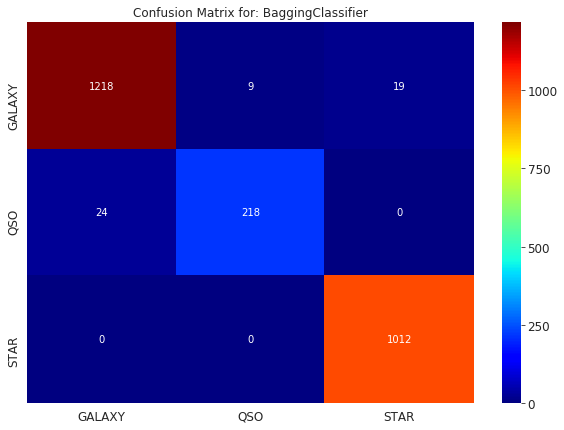

In [4]:
best_indiv = BaggingClassifier(n_estimators=261,
                               max_samples=46,
                               max_features=6,
                               bootstrap=False,
                               bootstrap_features=False,
                               oob_score=False,
                               n_jobs=4,
                               random_state=42)

clf_names = ["BaggingClassifier"]
class_names = ["GALAXY", "QSO", "STAR"]

clfs=[best_indiv]
data_sets = []
std_scaled_set = DataSet("Standard Scaled", X_train, y_train, X_test, y_test)
data_sets.append(std_scaled_set)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    helpers.learning_loop_for_sets(clfs, clf_names, class_names, data_sets)